In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import cv2
import math
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import scipy.ndimage
import matplotlib
import matplotlib.pyplot as plt
import skimage
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


Using TensorFlow backend.


In [2]:
'''from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection'''


data_dir = 'N:/PROJECT/stage1'
patients = os.listdir(data_dir)
labels = pd.read_csv('N:/PROJECT/labels.csv', index_col=0)

In [3]:
def load_scan(p):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(p)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

In [4]:
def get_pixels_hu(slices):
    image = [] 
    
       
    image.append([s.pixel_array for s in slices])
    
    image = np.array(image)
    l = len(slices)
    image = np.reshape(image,[l,512,512])
   
    
    image[image <= -2000] = 0

    for slice_number in range(len(slices)):
            
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
            
        if slope != 1:
            image[0][slice_number] = slope * image[0][slice_number].astype(np.float64)
            image[0][slice_number] = image[0][slice_number].astype(np.int16)
                    
        image[0][slice_number] = image[0][slice_number] + np.int16(intercept)
    return np.array(image, dtype=np.int16)

In [5]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing) , dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

    
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None 
    

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = skimage.measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = skimage.measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = skimage.measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [6]:
def plot_3d(image, threshold=400):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = skimage.measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.3, 0.3, 0.6]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
    
'''

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
'''

"\n\ndef plot_3d(image, threshold=-300):\n    \n    # Position the scan upright, \n    # so the head of the patient would be at the top facing the camera\n    p = image.transpose(2,1,0)\n    \n    verts, faces = measure.marching_cubes_lewiner(p, threshold)\n\n    fig = plt.figure(figsize=(10, 10))\n    ax = fig.add_subplot(111, projection='3d')\n\n    # Fancy indexing: `verts[faces]` to generate a collection of triangles\n    mesh = Poly3DCollection(verts[faces], alpha=0.70)\n    face_color = [0.45, 0.45, 0.75]\n    mesh.set_facecolor(face_color)\n    ax.add_collection3d(mesh)\n\n    ax.set_xlim(0, p.shape[0])\n    ax.set_ylim(0, p.shape[1])\n    ax.set_zlim(0, p.shape[2])\n\n    plt.show()\n"

In [7]:
def process_data(pix,patient,labels_df, hm_slices=20, visualize=False):
    
    label = labels_df.at[patient, 'cancer']
# =============================================================================
#     path = data_dir + '/' + patient
#     slices = [pydicom.read_file(path + '/' +s ) for s in os.listdir(path)]
#     slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
# 
# =============================================================================
    new_slices = []

    slices = [cv2.resize(p,(100,100)) for p in pix]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
        
        
    no = 20-len(new_slices)
    
    
    if no > 0:
        for s in range(no):    
            new_slices.append(new_slices[-1])    
        
    if no < 0:
        for j in range(abs(no)):
            new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
            del new_slices[hm_slices]
            new_slices[hm_slices-1] = new_val 
    
    print(len(slices), len(new_slices))        
            
    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
    
    return np.array(new_slices),label

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)
/n


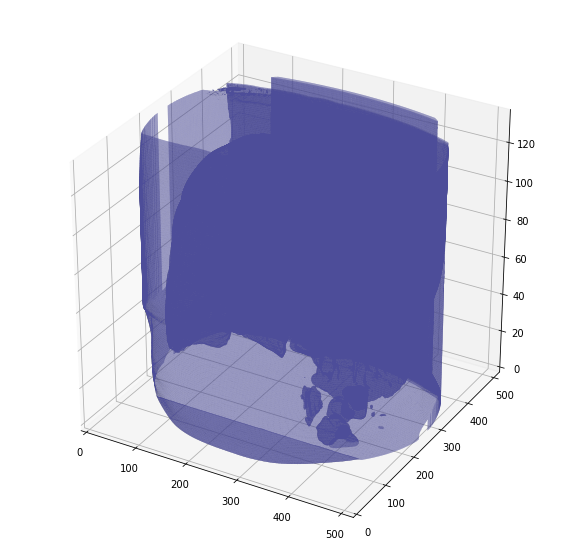

335 20
Shape before resampling	 (135, 512, 512)
Shape after resampling	 (338, 345, 345)
/n


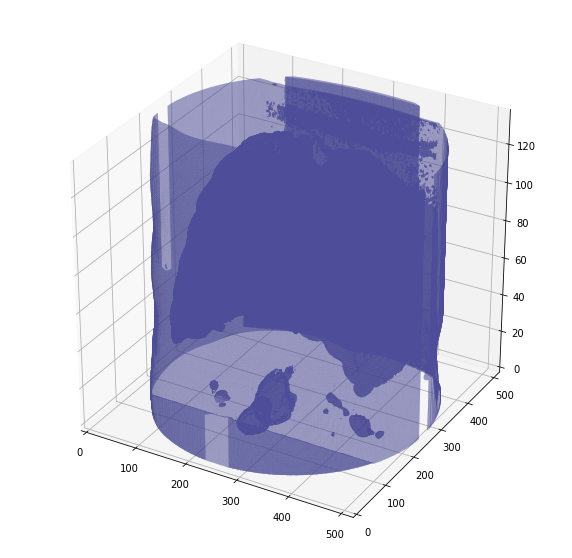

338 20
Shape before resampling	 (128, 512, 512)
Shape after resampling	 (320, 347, 347)
/n


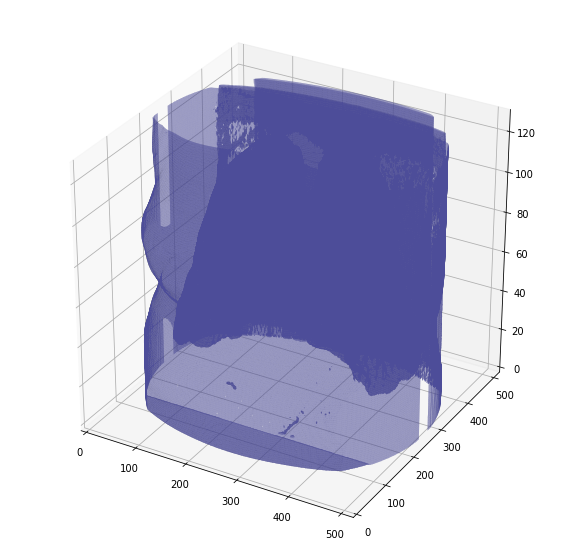

320 20
Shape before resampling	 (133, 512, 512)
Shape after resampling	 (332, 340, 340)
/n


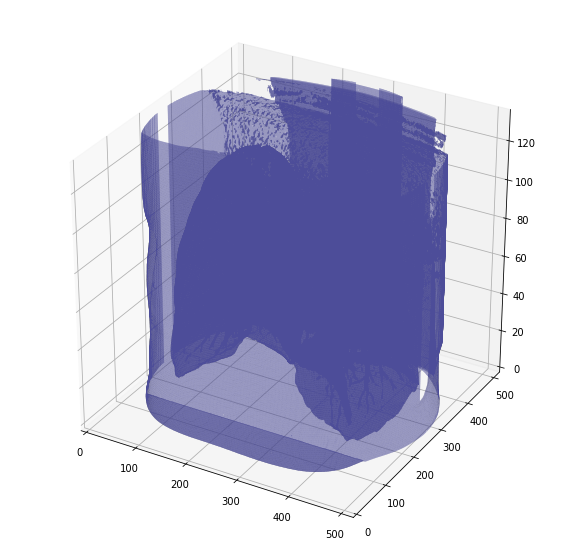

332 20
Shape before resampling	 (110, 512, 512)
Shape after resampling	 (275, 320, 320)
/n


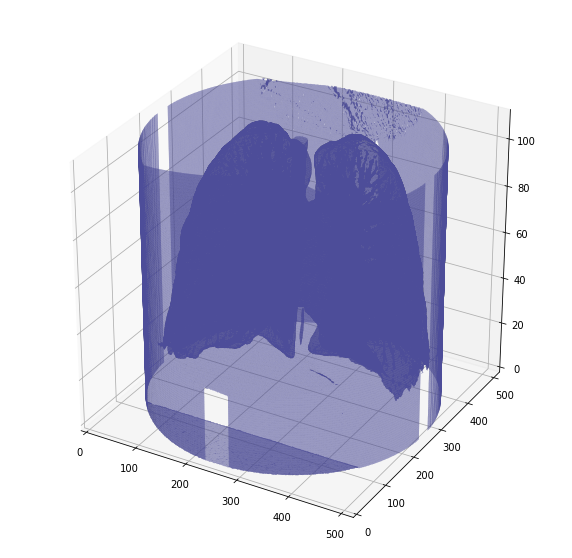

275 20
Shape before resampling	 (203, 512, 512)
Shape after resampling	 (365, 279, 279)
/n


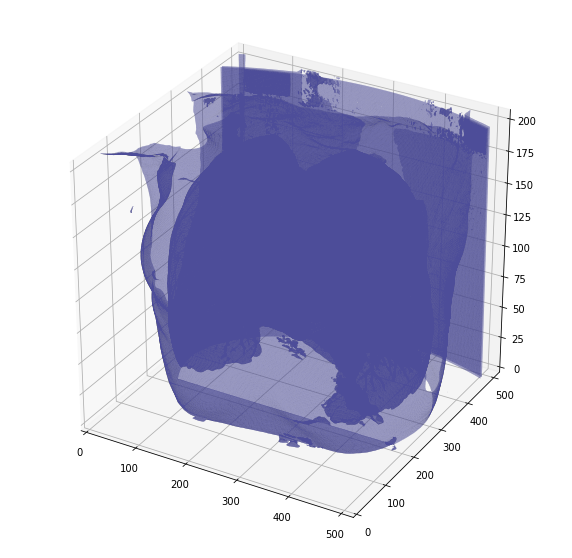

365 20
Shape before resampling	 (280, 512, 512)
Shape after resampling	 (350, 340, 340)
/n


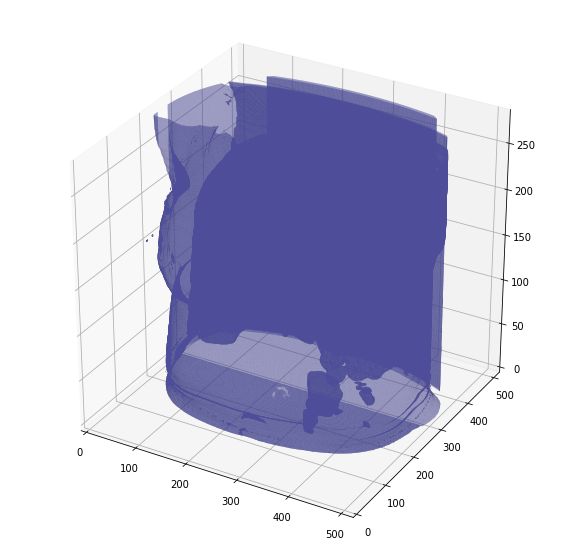

350 20
Shape before resampling	 (123, 512, 512)
Shape after resampling	 (308, 355, 355)
/n


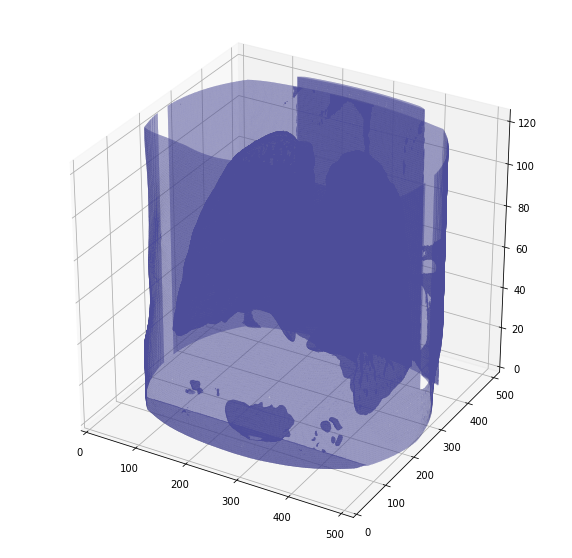

308 20
Shape before resampling	 (164, 512, 512)
Shape after resampling	 (328, 360, 360)
/n


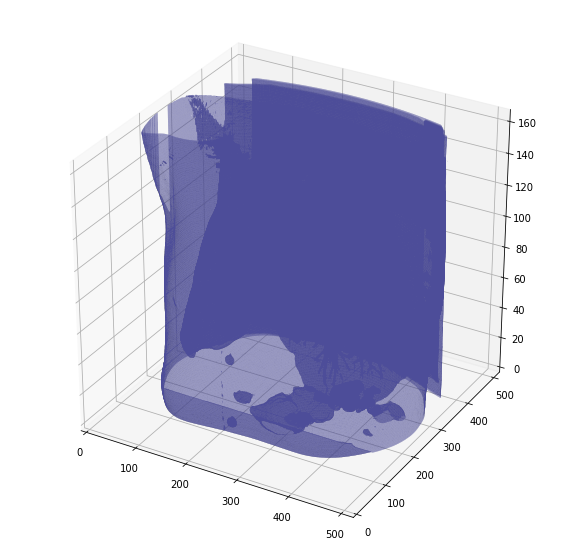

328 20
Shape before resampling	 (244, 512, 512)
Shape after resampling	 (305, 390, 390)
/n


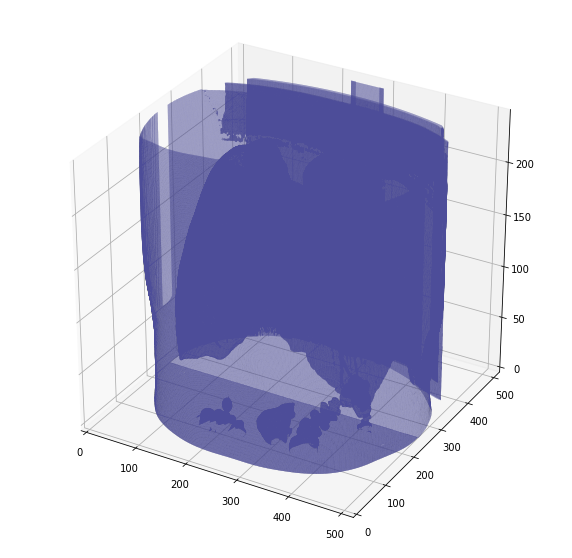

305 20
Shape before resampling	 (136, 512, 512)
Shape after resampling	 (272, 330, 330)
/n


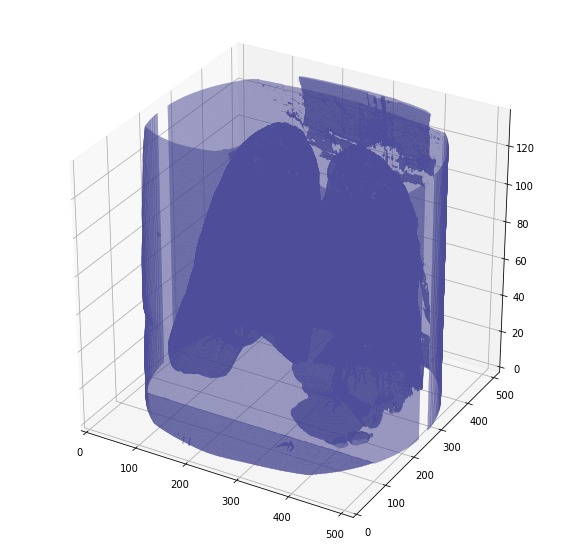

272 20
Shape before resampling	 (180, 512, 512)
Shape after resampling	 (360, 350, 350)
/n


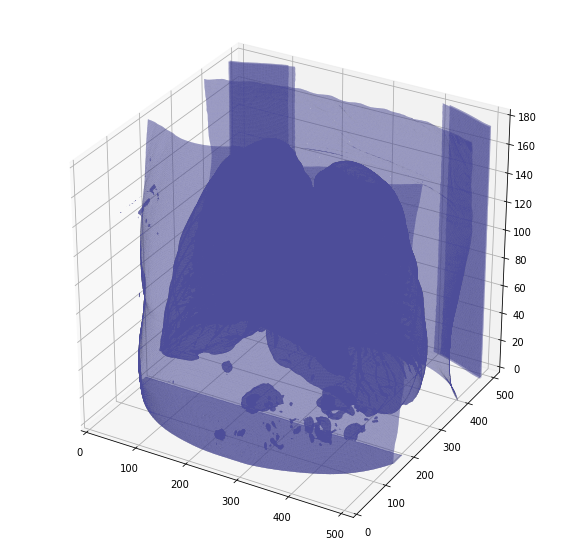

360 20
Shape before resampling	 (221, 512, 512)
Shape after resampling	 (398, 309, 309)
/n


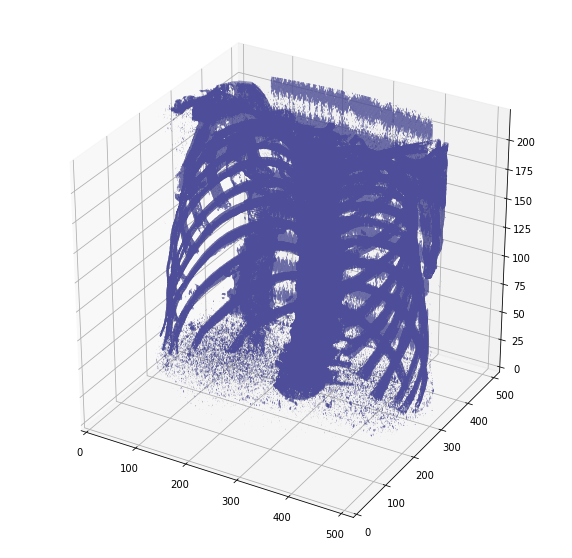

398 20
Shape before resampling	 (147, 512, 512)
Shape after resampling	 (294, 300, 300)
/n


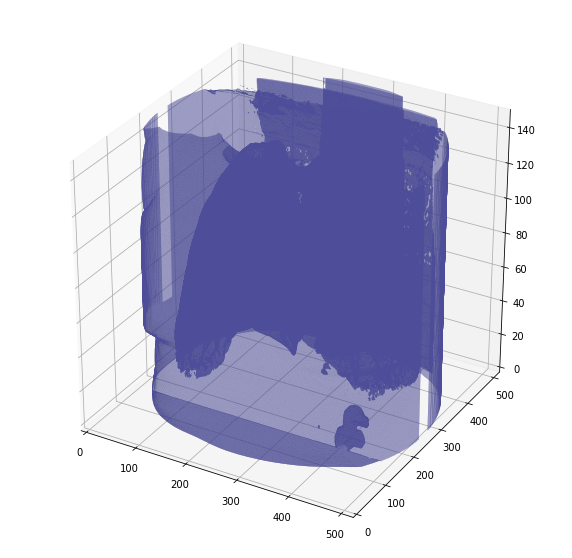

294 20


In [8]:
def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


IMG_SIZE_PX = 100
SLICE_COUNT = 20
much_data = []

for patient in patients:
    path = data_dir + '/' + patient
    first_patient = load_scan(path)
    first_patient_pixels = get_pixels_hu(first_patient)
    
    pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
    
    print("Shape before resampling\t", first_patient_pixels.shape)
    print("Shape after resampling\t", pix_resampled.shape)
    print("/n")
    
    plot_3d(first_patient_pixels,400)
    segmented_lungs = segment_lung_mask(pix_resampled, False)
    segmented_lungs_fill = segment_lung_mask(first_patient_pixels, True)
    
    #plot_3d(segmented_lungs,0)
    #plot_3d(segmented_lungs_fill,0)
    #plot_3d(segmented_lungs_fill - segmented_lungs, 0)
    
    
    img_data,label = process_data(pix_resampled,patient,labels, hm_slices=SLICE_COUNT)
    #print(img_data.shape,label)
    much_data.append([img_data,label])
    #last_pix = normalize(pix_resampled)

In [9]:
tr_img_data=[]
label_train=[]
s=np.array(much_data)


for i in range(0,14):
        z = np.array(s[i][0])
        tr_img_data.append(z)
        #label_train.append(s[i][1])
        
for i in range(0,14):
        m = np.array(s[i][1])
        label_train.append(m)
        
print(np.array(tr_img_data).shape,np.array(label_train).shape)    

(14, 20, 100, 100) (14, 2)


In [10]:
d=np.array(tr_img_data)
X = tf.reshape(d, shape=[-1,IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT])
Y=np.array(label_train)
print(X.shape,Y.shape) 

(14, 100, 100, 20) (14, 2)


In [11]:
# Initialising the CNN
classifier = Sequential()

classifier.add(keras.layers.InputLayer(input_shape=(100,100,1)))

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), activation = 'relu',padding='valid'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(Dropout(0.5))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu',padding='valid'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer

classifier.add(Conv2D(128, (3, 3), activation = 'relu',padding='valid'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


#Adding dropout
classifier.add(Dropout(0.8))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
#classifier.add(Dense(units = 2048, activation = 'relu'))
classifier.add(Dense(units = 1024, activation = 'relu'))
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dense(units = 2, activation = 'sigmoid'))

print(classifier.summary())

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 128)      

In [12]:
list_data = []
for i in range(0,14):
    for j in range(0,20):
        list_data.append([tr_img_data[i][j], label_train[i]])
list_data = np.array(list_data)

m = []
n = []
for i in range(0,280):
    m.append(list_data[i][0])
    n.append(list_data[i][1])
m = np.array(m)
n = np.array(n)

m = np.reshape(m,[280,100,100,1])

m.shape

classifier.fit(m,n,epochs = 15)


Epoch 1/15
280/280 [==============================] - 6s 22ms/step - loss: 143.7922 - accuracy: 0.5446
Epoch 2/15
280/280 [==============================] - 6s 21ms/step - loss: 1.4761 - accuracy: 0.6607
Epoch 3/15
280/280 [==============================] - 6s 21ms/step - loss: 0.5743 - accuracy: 0.7268
Epoch 4/15
280/280 [==============================] - 6s 21ms/step - loss: 0.4724 - accuracy: 0.7875
Epoch 5/15
280/280 [==============================] - 6s 21ms/step - loss: 0.4305 - accuracy: 0.8143
Epoch 6/15
280/280 [==============================] - 6s 21ms/step - loss: 0.4312 - accuracy: 0.8054
Epoch 7/15
280/280 [==============================] - 6s 21ms/step - loss: 0.4301 - accuracy: 0.7929
Epoch 8/15
280/280 [==============================] - 6s 21ms/step - loss: 0.4385 - accuracy: 0.8071
Epoch 9/15
280/280 [==============================] - 6s 21ms/step - loss: 0.4521 - accuracy: 0.7893
Epoch 10/15
280/280 [==============================] - 6s 21ms/step - loss: 0.4193 - accu

In [13]:

ds = pydicom.dcmread("N:/PROJECT/3b225245db9453efd9ad8a76b1598242.dcm")
ds1 = pydicom.dcmread("N:/PROJECT/7d71caeb22392e84f1d9d5b96429a5c7.dcm")

test_data = ds.pixel_array
test_data1 = ds1.pixel_array

test_data = cv2.resize(test_data, (100,100))
test_data1 = cv2.resize(test_data1, (100,100))


test_data = np.reshape(test_data, [1,100,100,1])
test_data1 = np.reshape(test_data1, [1,100,100,1])

pred = classifier.predict(test_data)
pred1 = classifier.predict(test_data1)

if pred[0][1] > 0.5 :
    print("The First test file patient has the cancerous cells.")
    print("The patient has cancerous cells.")
else:
    print("The First test file patient has the cancerous cells.")
    print("The patient does not have cancerous cells.")


if pred1[0][1] < 0.5 :
    print("The Second test file patient does not have cancerous cells.")
    print("The patient does not have cancerous cells.")
else:
    print("The Second test file patient does not have cancerous cells.")
    print("The patient has cancerous cells.")


The First test file patient has the cancerous cells.
The patient has cancerous cells.
The Second test file patient does not have cancerous cells.
The patient does not have cancerous cells.
